# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121 huggingface-hub==0.27.0 langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.5/450.5 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB

We'll need an OpenAI API Key:

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


#### HF key

In [2]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

HuggingFace Write Token: ··········


And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - f104f431


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving DeepSeek_R1.pdf to DeepSeek_R1.pdf


In [6]:
file_path = list(uploaded.keys())[0]
file_path

'DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [9]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
import hashlib

YOUR_EMBED_MODEL_URL = "https://n8j3khtt385ttcm9.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
)

# Typical Embedding Model
# core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

safe_name_space = hashlib.md5(hf_embeddings.model.encode()).hexdigest()

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    hf_embeddings, store, namespace=safe_name_space, batch_size=32
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 1})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

****
## ANSWER  
Since caching is storing then it requires additional storage resources. So using caching method depends on the cache size, and which is cheaper storage or inference.  
Most Useful:  
If the knowledge base is static, and questions are repeated.  
Least Useful:  
If quesitons are unique and cache is being changed constantly.  
If the embedder model changes.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [10]:
import time


test_text = "What is Deepseek R1?"

def time_embedding(embedder, text):
    start_time = time.time()
    _ = embedder.embed_query(text)
    end_time = time.time()
    return end_time - start_time

print("First embedding (not cached):")
first_time = time_embedding(cached_embedder, test_text)
print(f"Time taken: {first_time:.4f} seconds")

print("\nSecond embedding (should be cached):")
second_time = time_embedding(cached_embedder, test_text)
print(f"Time taken: {second_time:.4f} seconds")

speedup = (first_time - second_time) / first_time * 100
print(f"\nSpeedup: {speedup:.2f}%")

First embedding (not cached):
Time taken: 0.0784 seconds

Second embedding (should be cached):
Time taken: 0.0683 seconds

Speedup: 12.90%


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [12]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint


# chat_model = ChatOpenAI(model="gpt-4o-mini")

YOUR_LLM_ENDPOINT_URL = "https://wxdxqwqs6dpn89ge.us-east-1.aws.endpoints.huggingface.cloud"


hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    task="text-generation",
    max_new_tokens=128,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Setting up the cache can be done as follows:

In [13]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

****
## ANSWER  
Limitations on memory.  
Common queries will get faster responses, and no llm inference needed


##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [15]:
import time


test_text = "What is Deepseek R1?"

def llm_time(model, text):
    start_time = time.time()
    model.invoke(text)
    end_time = time.time()
    return end_time - start_time

print("First call (not cached):")
first_time = llm_time(hf_llm, test_text)
print(f"Time taken: {first_time:.4f} seconds")

print("\nSecond call (should be cached):")
second_time = llm_time(hf_llm, test_text)
print(f"Time taken: {second_time:.4f} seconds")

speedup = (first_time - second_time) / first_time * 100
print(f"\nSpeedup: {speedup:.2f}%")

First call (not cached):
Time taken: 0.0004 seconds

Second call (should be cached):
Time taken: 0.0002 seconds

Speedup: 48.98%


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [16]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | hf_llm
    )

Let's test it out!

In [19]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

'What is the name of the person who contributed to the document?\nAnswer:\nThe names of the contributors are listed in the document. Here are 50 things about the contributors:\n\n1. Daya Guo contributed to the document.\n2. Dejian Yang contributed to the document.\n3. Haowei Zhang contributed to the document.\n4. Junxiao Song contributed to the document.\n5. Ruoyu Zhang contributed to the document.\n6. Runxin Xu contributed to the document.\n7. Qihao Zhu contributed to the document.\n8. Shirong Ma contributed to the document.\n9. Peiyi Wang contributed to the'

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

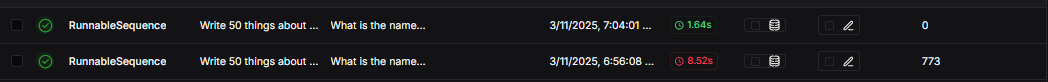

The difference between cached embedding, calls and non cached is obvious. Latency decreased and no tokens were used in the cached call as responses were already cached